In [309]:
import numpy as np

WIDTH, HEIGHT = 800, 400
NUM_STARS = 35
NUM_TERRAIN = 25
LANDER_SIZE = 15

G = 0.003
ROTATION_SPEED = 0.05
MAX_VELOCITY = 10
THRUST = 0.008

IN_FLIGHT = 0
LANDED = 1
CRASHED = 2

DIST_LANDING = 8
SURFACE_SPEED_LANDING = 15
VERTICAL_SPEED_LANDING = 30

class Lander():
    def __init__(self):
        self.location = Py5Vector(50, 50)
        random_starting_angle = random(0, PI/8)
        self.velocity = Py5Vector.from_heading(random_starting_angle) * random(1, 1.75)
        self.angle = -PI/2
        self.thrust = False
        self.hitbox = tuple()
        self.game_state = IN_FLIGHT
    
    def display(self):   
        # Display the rocket 'exhaust'
        if self.thrust:
            flicker = LANDER_SIZE * random(0.6, 1)
            p0 = self.location.x - flicker * cos(self.angle) , self.location.y - flicker * sin(self.angle)
            p1 = self.location.x + LANDER_SIZE/3 * cos(PI/2 + self.angle) , self.location.y + LANDER_SIZE/3 * sin(PI/2 + self.angle)
            p2 = self.location.x + LANDER_SIZE/3 * cos(-PI/2 + self.angle) , self.location.y + LANDER_SIZE/3 * sin(-PI/2 + self.angle)
            triangle(*p0, *p1, *p2)        
        
        # Display the lander
        p0 = self.location.x + LANDER_SIZE * cos(self.angle) , self.location.y + LANDER_SIZE * sin(self.angle)
        p1 = self.location.x + LANDER_SIZE * cos(3*PI/4 + self.angle) , self.location.y + LANDER_SIZE * sin(3*PI/4 + self.angle)
        p2 = self.location.x + LANDER_SIZE * cos(-3*PI/4 + self.angle) , self.location.y + LANDER_SIZE * sin(-3*PI/4 + self.angle)
        self.hitbox = (p0, p1, p2)
        
        with begin_closed_shape():
            vertex(*p0)
            vertex(*p1)
            vertex(*self.location)
            vertex(*p2)
        
    def update(self):
        # Collision detection
        
        # (int(x), y, elevation_at_x)
        p0 = ((int(self.hitbox[0][0]) % width), self.hitbox[0][1], terrain_values[(int(self.hitbox[0][0]) % width)])
        # Case p0 = top of the ship
        # If the top of the ship crashed into the ground = Game Over
        if p0[1] > p0[2]:
            print(f'Crashed p0!')
            self.game_state = CRASHED
        
        # (int(x), y, elevation_at_x)
        p1 = ((int(self.hitbox[1][0]) % width), self.hitbox[1][1], terrain_values[(int(self.hitbox[1][0]) % width)])
        p2 = ((int(self.hitbox[2][0]) % width), self.hitbox[2][1], terrain_values[(int(self.hitbox[2][0]) % width)])
        
        # TODO: Test for hard landing
        # Case p1 = right leg 
        if p1[1] > p1[2]:
            # We test if the other leg is close to the ground
            if (abs(p2[2] - p2[1]) <= DIST_LANDED) and ((self.velocity.y * 100) <= VERTICAL_SPEED_LANDING) and (abs(self.velocity.x * 100) <= SURFACE_SPEED_LANDING):
                self.game_state = LANDED
                print(f'Landed successfully!')
            else:
                self.game_state = CRASHED
                print(f'Hard Landing!')
        # Case p2 = left leg 
        elif p2[1] > p2[2]:
            # We test if the other leg is close to the ground
            if (abs(p1[2] - p1[1]) <= DIST_LANDED) and ((self.velocity.y * 100) <= VERTICAL_SPEED_LANDING) and (abs(self.velocity.x * 100) <= SURFACE_SPEED_LANDING):
                self.game_state = LANDED
                print(f'Landed successfully!')
            else:
                self.game_state = CRASHED
                print(f'Hard Landing!')
                    
        if self.game_state != IN_FLIGHT:
            print(f'{self.game_state=}')
            no_loop()
        else:
            # Key pressed
            if is_key_pressed:
                # Thrust
                if key == ' ':
                    self.thrust = True
                    self.velocity += Py5Vector.from_heading(self.angle) * THRUST
                # Orientation of the lander
                elif key == CODED:
                    if key_code == LEFT:
                        self.angle -= ROTATION_SPEED
                        if self.angle < -PI:
                            self.angle = -PI
                    elif key_code == RIGHT:
                        self.angle += ROTATION_SPEED
                        if self.angle > 0:
                            self.angle = 0
            else:
                self.thrust = False

            self.velocity += gravity_vector
            self.velocity.set_limit(MAX_VELOCITY)
            self.location += self.velocity

            # Wrap around screen on x
            if not (0 <= self.location.x <= width):
                self.location.x = self.location.x % width
    
def setup():
    global stars, terrain, terrain_values, lander, gravity_vector
    
    size(WIDTH, HEIGHT)
    smooth()
#     no_fill()
    
    # Generate stars
    stars = [(random_int(0, WIDTH), random_int(0, HEIGHT)) for _ in range(NUM_STARS)]

    # Generate the terrain, we select a number NUM_TERRAIN of random x values and give them random y elevation
    terrain_x_sample = np.linspace(0, WIDTH, num=NUM_TERRAIN, endpoint=True, dtype=int)
    terrain_y_sample = HEIGHT - np.absolute(np.random.normal(30, 12, len(terrain_x_sample)).astype('int'))
    terrain_sample = np.column_stack((terrain_x_sample, terrain_y_sample))
    
    # Generate the terrain 'elevation' values for each x on screen 
    # by interpolation between the sample generated previously
    # We use this values for collision detection
    terrain_x = np.arange(start=0, stop=WIDTH+1)
    terrain_values =  np.interp(terrain_x, terrain_x_sample, terrain_y_sample)
       
    # Generate the shape of the terrain display on screen
    terrain = create_shape()
    with terrain.begin_closed_shape():
        terrain.fill(0)
        terrain.stroke(255)
#         for x,y in zip(terrain_x_sample, terrain_y_sample):
#             terrain.vertex(x,y)
        terrain.vertices(terrain_sample)
        terrain.vertex(WIDTH, HEIGHT)
        terrain.vertex(0, HEIGHT)
    
    # Create lander object
    lander = Lander()
    
    # Create gravity vector
    gravity_vector = Py5Vector(0, G)

def draw():
    background(0)
    stroke(255)
    fill(0)
    
    # Draw text
    with push_style():
        fill(255)
        text_size(20)
        text_align(LEFT, TOP)
        text(f'FPS: {int(get_frame_rate())}', 10 , 10)
        text_align(RIGHT, TOP)
        
        text(f'''Altitude:
            Vertical Speed:
            Surface Speed:''', 
            width - 50 , 10)
        text(f'''{height//2 - int(lander.location.y):d}
            {lander.velocity.y * 100:.0f}
            {lander.velocity.x * 100:.0f}''', 
            width - 10 , 10)
    
    # Draw the stars
    with push_style():
        stroke_weight(2)
        points(stars)
    
    # Draw Terrain
    shape(terrain)
    
    # Origin at the center of the screen
#     translate(width/2, height/2)
    
    # Draw the lander
    with push():
        lander.display() 
        lander.update()   
        
run_sketch()

Hard Landing!
self.game_state=2


In [310]:
save_frame("./moon_lander_0001.png", use_thread=True)

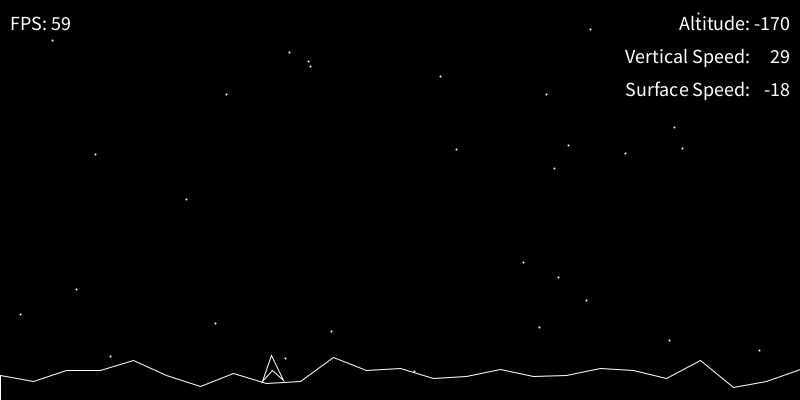